# Convolutional Nueral Net From Scratch

For UCLA Math 156: Machine Learning with Prof. Lara Kassab, Spring 2024 \
Created by Sia Phulambrikar, Anya Smolentseva, and Nathan Wetmore

## Imports and Data Preprocessing

Note: to run this code please dowload the Tom and Jerry dataset from Kaggle [here](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification).\
You will need to drag all images from the four seperate class folders into a single new folder titled `frames`. The `frames` folder and the `ground_truths.csv` must be located in the same directory as this notebook.

In [36]:
#imports required for code
import pandas as pd
import cv2 #run pip install opencv-python
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image

### Image Samples

In [37]:
#set the image size we want to use
desired_width = 224
desired_height = 224

In [39]:
# Read ground truth CSV
ground_truth = pd.read_csv('ground_truth.csv')

# Sort the CSV by filename
ground_truth = ground_truth.sort_values(by='filename').reset_index(drop=True)

# Get sorted list of filenames
csv_filenames = ground_truth['filename'].values

# Function to load and preprocess a single image
def load_and_preprocess_image(filename):
    img = cv2.imread(os.path.join('images', filename))
    if img is not None:
        if len(img.shape) == 2 or img.shape[2] == 1:
            gray_img = img
        else:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_img = cv2.resize(gray_img, (desired_width, desired_height))
        gray_img = gray_img / 255.0
        return gray_img
    else:
        return None

# Load images in the order specified by the CSV file
images = []
for filename in tqdm(csv_filenames):
    img = load_and_preprocess_image(filename)
    if img is not None:
        images.append(img)

# Convert images to a NumPy array
images = np.array(images)

# Check shapes to confirm everything is correct
print(images.shape)


100%|█████████████████████████████████████████████████████████████████████████████| 5478/5478 [00:48<00:00, 112.86it/s]


(5478, 224, 224)


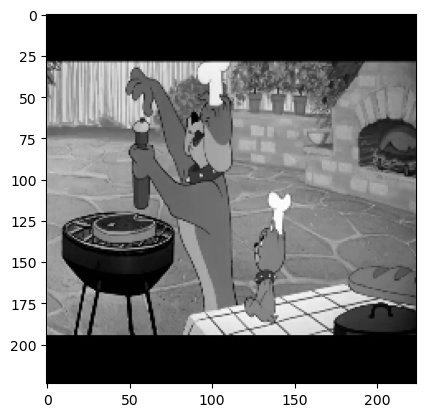

In [34]:
plt.imshow(images[0],cmap='gray')

In [54]:
images.shape

(5478, 224, 224)

### Target Values

In [55]:
#read in classifications
y_true = pd.read_csv('ground_truth.csv')
y_true.head()

,filename,tom,jerry
0,frame0.jpg,0,0
1,frame1.jpg,0,0
2,frame2.jpg,0,0
3,frame3.jpg,0,0
4,frame4.jpg,0,0


In [56]:
def class_creator(row):
    '''
    returns a class 0-3 for the 4 image classes
    -row: dataframe row to be worked with
    '''
    #only tom is in the frame = class 0
    if (row['tom'] == 1) & (row['jerry'] == 0):
        val = 0
    #only jerry is in the frame = class 1
    elif (row['tom'] == 0) & (row['jerry'] == 1):
        val = 1
    #neither tom nor jerry is in the frame = class 2
    elif (row['tom'] == 0) & (row['jerry'] == 0):
        val = 2
    #both tom and jerry are in the frame = class 3
    else:
        val = 3
    return val

In [57]:
ground_truth['class'] = ground_truth.apply(class_creator, axis=1)
y_true = ground_truth['class'].values

In [58]:
y_true.shape

(5478,)

## Model Creation

### Convolution Layer

In [59]:
class Conv2D:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9 
        
    def iterate_regions(self,image):
        h, w = image.shape
        for i in range(h-2):
            for j in range (w-2):
                region = image[i:(i+3), j:(j+3)]
                yield region, i, j
                
    def forward(self, input_val):
        self.last_input = input_val
        h, w = input_val.shape
        output = np.zeros ((h-2,w-2,self.num_filters))
        for region, i, j in self.iterate_regions(input_val):
            output[i,j] = np.sum(region * self.filters, axis=(1,2))
        
        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        # We aren't returning anything here since we use Conv3x3 as the first layer in our CNN.
        # Otherwise, we'd need to return the loss gradient for this layer's inputs, just like every
        # other layer in our CNN.
        return None


### Pooling Layer

In [60]:
class MaxPooling2D:
    def iterate_regions(self, image):
        '''
        Generates non-overlapping 2x2 image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield region, i, j
            
    def forward(self, input_val):
        self.last_input = input_val

        h, w, num_filters = input_val.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input_val):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output
    
    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

### Dense Softmax Layer

In [61]:
class Softmax:
  # A standard fully-connected layer with softmax activation.

    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
        Performs a forward pass of the softmax layer using the given input.
        Returns a 1d numpy array containing the respective probability values.
        - input can be any array with any dimensions.
        '''
        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input
        
        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

          # e^totals
        t_exp = np.exp(self.last_totals)

        # Sum of all e^totals
        S = np.sum(t_exp)

        # Gradients of out[i] against totals
        d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
        d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

        # Gradients of totals against weights/biases/input
        d_t_d_w = self.last_input
        d_t_d_b = 1
        d_t_d_inputs = self.weights

        # Gradients of loss against totals
        d_L_d_t = gradient * d_out_d_t

        # Gradients of loss against weights/biases/input
        d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
        d_L_d_b = d_L_d_t * d_t_d_b
        d_L_d_inputs = d_t_d_inputs @ d_L_d_t

        # Update weights / biases
        self.weights -= learn_rate * d_L_d_w
        self.biases -= learn_rate * d_L_d_b

        return d_L_d_inputs.reshape(self.last_input_shape)

### The Model Class

In [62]:
class CNN: 
    def __init__(self,num_filters,img_size,num_classes):
        self.num_filters = num_filters
        self.pool_out_dim = int((img_size[0] - 2) / 2)
        self.num_classes = num_classes
        self.test = 2
        self.conv = Conv2D(self.num_filters)                  
        self.pool = MaxPooling2D()                  
        self.softmax = Softmax(self.pool_out_dim * self.pool_out_dim * self.num_filters, 
                               self.num_classes)
    
    def forward(self, image, label):
        '''
        Completes a forward pass of the CNN and calculates the accuracy and
        cross-entropy loss.
        - image is a 2d numpy array
        - label is a digit
        '''
        out = self.conv.forward(image)
        out = self.pool.forward(out)
        out = self.softmax.forward(out)

        # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
        loss = -np.log(out[label])
        acc = 1 if np.argmax(out) == label else 0

        return out, loss, acc

    def train_im(self, im, label, lr=.005):
        '''
        Completes a full training step on the given image and label.
        Returns the cross-entropy loss and accuracy.
        - image is a 2d numpy array
        - label is a digit
        - lr is the learning rate
        '''
        # Forward
        out, loss, acc = self.forward(im, label)

        # Calculate initial gradient
        gradient = np.zeros(4)
        gradient[label] = -1 / out[label]

        # Backprop
        gradient = self.softmax.backprop(gradient, lr)
        gradient = self.pool.backprop(gradient)
        gradient = self.conv.backprop(gradient, lr)

        return out, loss, acc
    
        
        
    def train_model(self, X, y, lr=0.005):
        total_loss = []
        num_images = X.shape[0]
        for i in tqdm(range(num_images)):
            _, loss, acc = self.train_im(X[i], y[i], lr=lr)
            total_loss.append(loss)
        plt.plot(range(1, num_images + 1), total_loss)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Model Loss over Time')

        
    def predict(self):
        return
    
    def evaluate(self):
        return

## Running the Model

In [63]:
mymodel = CNN(8,images[0].shape,4)

In [ ]:
mymodel.train_model(images[0:50], y_true, lr = 0.001)

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:24<00:09,  3.12s/it]

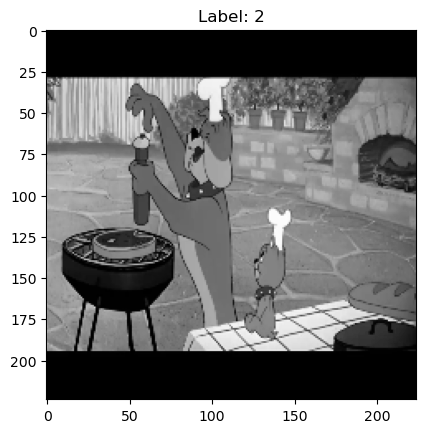

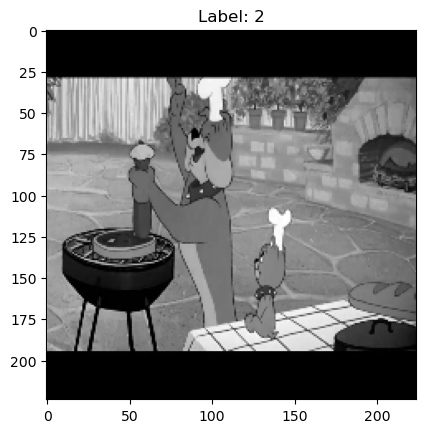

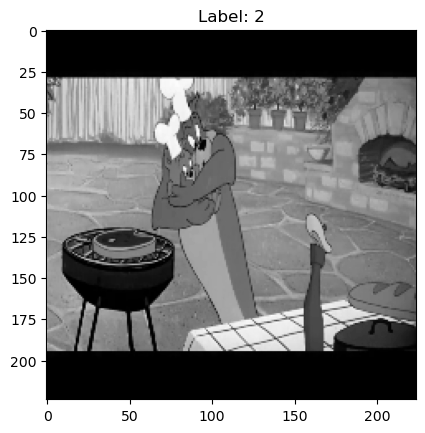

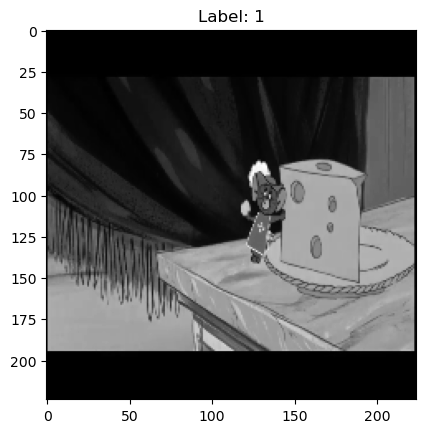

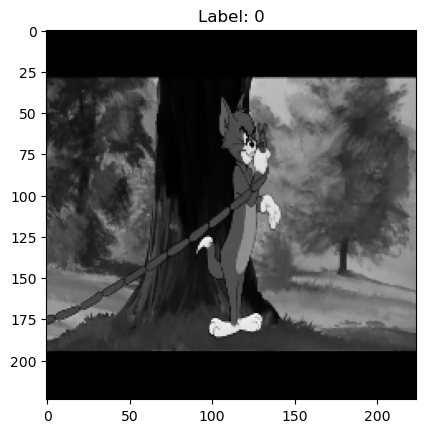

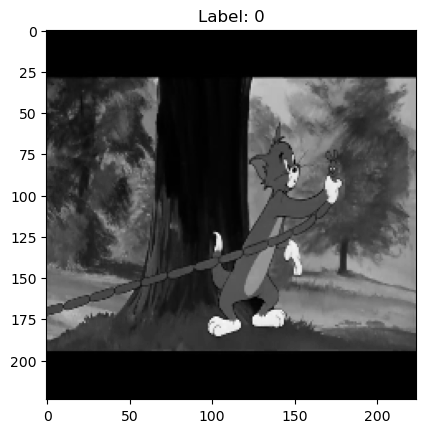

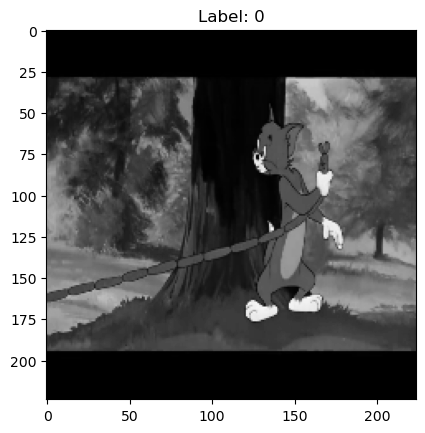

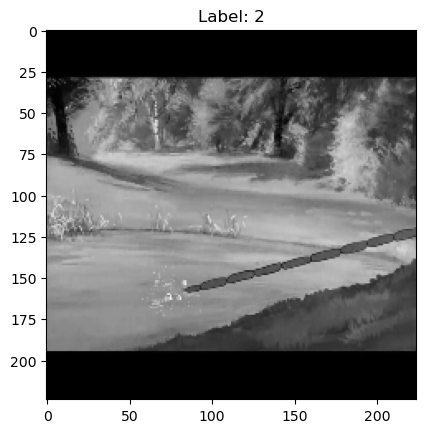

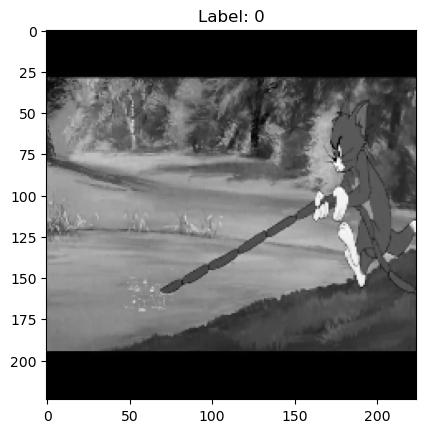

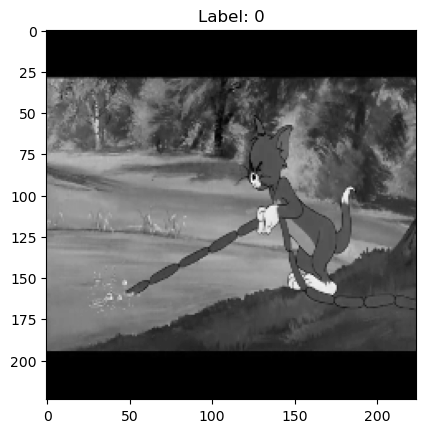

In [53]:
# Check a few images
for i in range(10):
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {y_true[i]}")
    plt.show()